In [6]:
from gibbs.dataclass import GibbsResult
import matplotlib.pyplot as plt
import numpy as np
from gibbs.learning.bayesian_learning import BayesianLearning
from gibbs.learning.constraint_matrix import ConstraintMatrixFactory
from qiskit.quantum_info import Statevector
from gibbs.utils import number_of_elements
from scipy.sparse import bmat
# plt.rcParams['text.usetex'] = True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
gibbs_result_list = []
folder_path = "saved_simulations/turbo/allcontrols8heisenberg/"
for file in os.listdir(folder_path):
    if file.endswith(".npy"):
        path = os.path.join(folder_path, file)
        gibbs_result_list.append(GibbsResult.load(path))

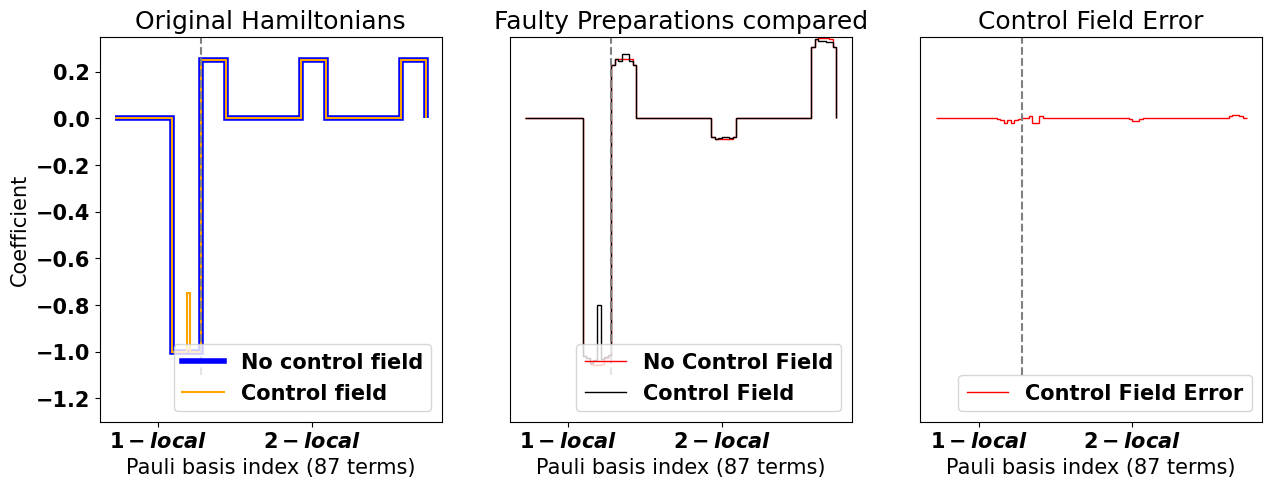

In [3]:
control_field = 4
result_nocfield = gibbs_result_list[0]
result_cfield = gibbs_result_list[control_field+1]
font = {#'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)

func = np.real

loc1 = number_of_elements(1,result_cfield.num_qubits)
loc2 = number_of_elements(2,result_cfield.num_qubits)
fig,ax = plt.subplots(1,3,figsize=(15,5))

ax[0].stairs(func(result_nocfield.coriginal),lw=4, label="No control field",color = "blue")
ax[0].stairs(func(result_cfield.coriginal),linestyle = "-",lw=1.5, label="Control field",color = "orange")
ax[0].set_ylabel("Coefficient")
ax[0].set_title("Original Hamiltonians")
ax[0].legend(loc="lower right")

ax[1].stairs(func(result_nocfield.cfaulties[-1]),linestyle = "-", label="No Control Field",color = "red")
ax[1].stairs(func(result_cfield.cfaulties[-1]),linestyle = "-", label="Control Field",color = "black")
ax[1].set_xlabel("Pauli basis index")
ax[1].set_yticks([])
ax[1].set_title("Faulty Preparations compared")
ax[1].legend(loc="lower right")

ax[2].stairs(func((result_nocfield.cfaulties[-1]-result_nocfield.coriginal)-(result_cfield.cfaulties[-1]-result_cfield.coriginal)),linestyle = "-", label="Control Field Error",color = "red")
ax[2].set_xlabel("Pauli basis index")
ax[2].set_yticks([])
ax[2].set_title("Control Field Error")
ax[2].legend(loc="lower right")

for ax_label in ax:
    ax_label.set_ylim(-1.3,0.35)
    ax_label.vlines(number_of_elements(1,result_cfield.num_qubits),-1.1,0.35,linestyle = "--",color = "gray")
    ax_label.set_xticks((loc1//2,loc1+loc2//2))
    ax_label.set_xticklabels(('$1-local$', '$2-local$'), size='medium')
    ax_label.set_xlabel(f"Pauli basis index ({len(result_nocfield.coriginal)} terms)")

In [7]:
states=[Statevector(result.state) for result in gibbs_result_list]
constraint_matrix_factory= ConstraintMatrixFactory(8,2,2)
constraint_matrices = [constraint_matrix_factory.create_constraint_matrix(state) for state in states]

In [25]:
l = [[constraint_matrices[0]]+[None]*(len(constraint_matrices)-1)]+[[c]+[None]*i + [c] +[None]*(len(constraint_matrices)-i-2) for i,c in enumerate(constraint_matrices[1:])]
A=bmat(l)

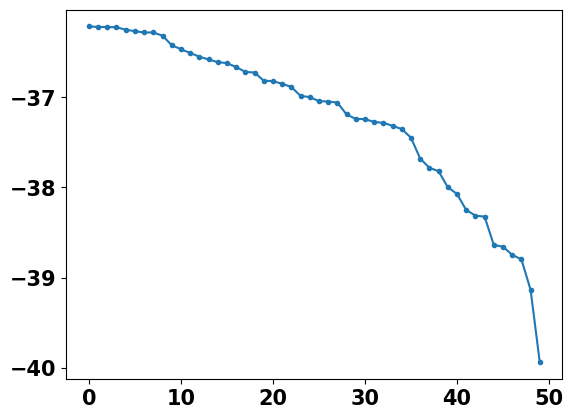

In [40]:
s= np.linalg.svd(A.todense(),hermitian=True,compute_uv=False)
plt.plot(np.log(s[-50:]),marker=".")

In [65]:
c_original = gibbs_result_list[0].coriginal
bl = BayesianLearning(
    states=[Statevector(result.state) for result in gibbs_result_list],
    control_fields= [result.coriginal - c_original for result in gibbs_result_list],
    constraint_matrix_factory= ConstraintMatrixFactory(8,2,3),
    prior_mean=c_original,
    prior_c_cov=np.eye(c_original.shape[0])*1e-2,
    prior_cfield_cov=np.eye(c_original.shape[0])*1e-3,
    sampling_std= 1e-3,   
)

In [66]:
assert bl.constraint_matrices is None, "The constraint matrices have already been built"
bl.constraint_matrix(0);

In [67]:
# update = bl.update_mean(1)

In [68]:
# cov = bl.update_cov(update,1)

In [72]:
for i in range(1,3):
    update = bl.update_mean(i)
    cov = bl.update_cov(update,i)
    bl.current_mean = update[:update.size//2]
    bl.current_cov = cov[:cov.shape[0]//2,:cov.shape[1]//2]

(174, 174)


ValueError: dimension mismatch

/home/drudis/python_environements/test_easy_instalation/lib64/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


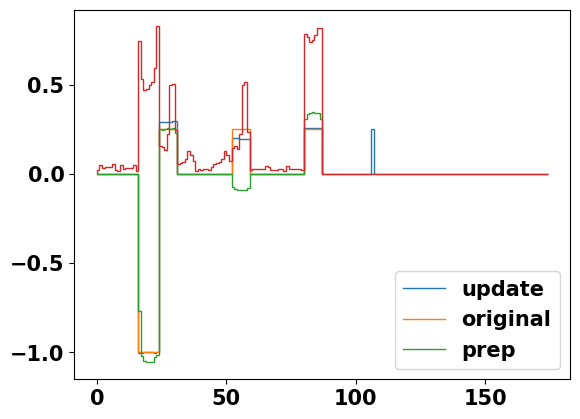

In [ ]:
plt.stairs(update[:update.size],label="update")
plt.stairs(c_original,label="original")
plt.stairs(gibbs_result_list[1].cfaulties[-1],label="prep")
# plt.stairs(gibbs_result_list[0].cfaulties[-1],label="control prep")
plt.stairs(cov.diagonal()[:cov.diagonal().size])
plt.legend(loc="lower right")